# Naive way to calculate loss and gradient

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import time 

def svm_loss_naive(W, X, y, reg):
    d, C = W.shape
    _, N = X.shape

    loss = 0
    dW = np.zeros_like(W)
    for n in range(N):
        xn = X[:, n]
        score = W.T.dot(xn)
        for j in range(C):
            if j==y[n]:
                continue
            margin = 1 - score[y[n]] +score[j]
            if margin > 0:
                loss += margin
                dW[:, j] += xn
                dW[:, y[n]] -= xn
    
    loss /= N
    loss += 0.5*reg*np.sum(W*W)
    dW /= N
    dW += reg*W
    
    return loss, dW

N, C, d = 10, 3, 5
W = np.random.randn(d, C)
X = np.random.randn(d, N)
y = np.random.randint(C, size=N)

print('Loss without regularization:', svm_loss_naive(W, X, y, 0)[0])
print('Loss with regularization:', svm_loss_naive(W, X, y, 0.1)[0])


Loss without regularization: 6.443917350191055
Loss with regularization: 7.554177384246895


In [26]:
f = lambda W: svm_loss_naive(W, X, y, 0.1)[0]

def numerical_grad_general(W, f):
    eps = 1e-6
    g = np.zeros_like(W)

    W_flattened = W.flatten()
    g_flattened = np.zeros_like(W_flattened)

    for i in range(W.size):
        W_p = W_flattened.copy()
        W_n = W_flattened.copy()
        W_p[i] += eps
        W_n[i] -= eps

        W_p = W_p.reshape(W.shape)
        W_n = W_n.reshape(W.shape)
        g_flattened[i] = (f(W_p) - f(W_n))/(2*eps)
    
    return g_flattened.reshape(W.shape)

g1 = svm_loss_naive(W, X, y, 0.1)[1]
g2 = numerical_grad_general(W, f)
print('Gradient different', np.linalg.norm(g1 - g2))

Gradient different 3.1612752429049813e-09


# Calcuate loss and gradient with vectorization

In [27]:
def svm_loss_vectorized(W, X, y, reg): # e.g: N = 5, C = 3, d = 4
    d, C = W.shape 
    _, N = X.shape 
    loss = 0 
    dW = np.zeros_like(W)

    Z = W.T.dot(X)
    # e.g: y = [0 1 2 0 2]
    #      Z = [[ 3.11858146  0.03385199 -0.2407119  -1.06607825 -2.59761588]
    #           [-3.08404402  1.85173927  0.2907681   1.75411857  2.30619145]
    #           [-4.07148415  0.80598184 -1.15251673  1.64579593  5.96190991]]
    
    correct_class_score = np.choose(y, Z).reshape(N, 1).T # choose z_yn
    # np.choose(y,Z) = [3.11858146  1.85173927 -1.15251673 -1.06607825  5.96190991]
    # correct_class_score = [[ 3.11858146  1.85173927 -1.15251673 -1.06607825  5.96190991]]

    margins = np.maximum(0, 1 - correct_class_score + Z)
    # margins = [[1.         0.         1.91180483 1.         0.        ]
    #            [0.         1.         2.44328483 3.82019681 0.        ]
    #            [0.         0.         1.         3.71187417 1.        ]]
    # margins[y, np.arange(margins.shape[1])]: margins[0, 0] = margins[1, 1] = margins[2, 2] = margins[0, 3] = margins[2, 4] = 1
    margins[y, np.arange(margins.shape[1])] = 0
    
    loss = np.sum(margins, axis=(0, 1))
    loss /= N
    loss += 0.5*reg*np.sum(W*W)

    F = (margins > 0).astype(int)
    # F = [[0 0 1 0 0]
    #      [0 0 1 1 0]
    #      [0 0 0 1 0]]
    F[y, np.arange(F.shape[1])] = np.sum(-F, axis=0)
    # F = [[ 0  0  1 -2  0]
    #      [ 0  0  1  1  0]
    #      [ 0  0 -2  1  0]]
    dW = X.dot(F.T)/N + reg*W
    return loss, dW

In [28]:
N, C, d = 5, 3, 4
reg = .1 
W = np.random.randn(d, C)
X = np.random.randn(d, N)
y = np.random.randint(C, size = N)
np.random.seed(2)

t1 = time.time()
l1, dW1 = svm_loss_naive(W, X, y, reg)
t2 = time.time()
print('Naive: run time:', t2 - t1, '(s)')

t1 = time.time()
l2, dW2 = svm_loss_vectorized(W, X, y, reg)
t2 = time.time()
print('Vectorized: run time:', t2 - t1, '(s)')
print('loss difference:', np.linalg.norm(l1 - l2))
print('gradient difference:', np.linalg.norm(dW1 - dW2))


Naive: run time: 0.00023865699768066406 (s)
Vectorized: run time: 0.00028252601623535156 (s)
loss difference: 8.881784197001252e-16
gradient difference: 1.1102230246251565e-16


It 1/1000, loss = 1748.425423
It 101/1000, loss = 246.153509
It 201/1000, loss = 56.164234
It 301/1000, loss = 41.880521
It 401/1000, loss = 44.352071
It 501/1000, loss = 35.767882
It 601/1000, loss = 43.637357
It 701/1000, loss = 38.216415
It 801/1000, loss = 42.089773
It 901/1000, loss = 42.202983


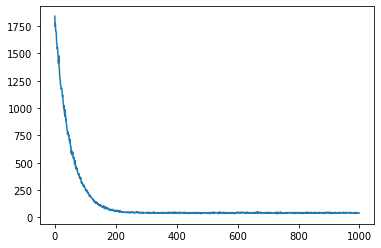

In [29]:
# Mini-batch gradient descent
def multiclass_svm_GD(X, y, Winit, reg, lr=.1, batch_size = 100, num_iters = 1000, print_every = 100):
    W = Winit 
    loss_history = np.zeros((num_iters))
    for it in range(num_iters):
        # randomly pick a batch of X
        idx = np.random.choice(X.shape[1], batch_size)
        X_batch = X[:, idx]
        y_batch = y[idx]

        loss_history[it], dW = svm_loss_vectorized(W, X_batch, y_batch, reg)

        W -= lr*dW 
        if it % print_every == 1:
            print ('It %d/%d, loss = %f' %(it, num_iters, loss_history[it]))

    return W, loss_history 

N, C, d = 49000, 10, 3073
reg = .1 
W = np.random.randn(d, C)
X = np.random.randn(d, N)
y = np.random.randint(C, size = N)

W, loss_history = multiclass_svm_GD(X, y, W, reg)

plt.plot(loss_history)
plt.show()